# Using the Diffussers Library

In [1]:
device = "cuda"

In [2]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [4]:
!rm -rf ./imitools && git clone https://github.com/GDi4K/imitools.git
!pip install -q duckduckgo_search

Cloning into 'imitools'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 119 (delta 62), reused 33 (delta 15), pack-reused 0
Receiving objects: 100% (119/119), 5.78 MiB | 4.91 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [5]:
import imitools as I

## Demo

This is what we are going to do at the end.

In [6]:
from diffusers import DDPMPipeline
demo_pipe = DDPMPipeline.from_pretrained("johnowhitaker/ddpm-butterflies-32px").to(device)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

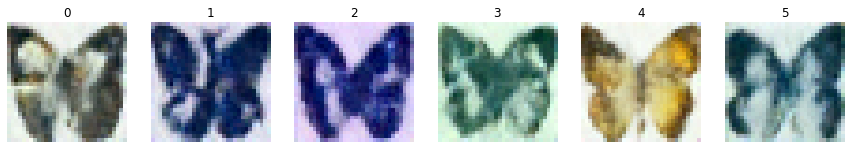

In [7]:
images = demo_pipe(batch_size=6).images
I.wrap(images).show()

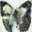

In [8]:
I.wrap(images).pick(0).pil()

In [9]:
I.wrap(images).pick(0).pt().shape

torch.Size([1, 3, 32, 32])

Yep. They are quite small images :)

## 1. Load Data

Here we are going load a very small butterfly dataset where we try to train on.

In [10]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

Using custom data configuration huggan--smithsonian_butterflies_subset-7665b1021a37404c
Found cached dataset parquet (/home/.cache/huggingface/datasets/huggan___parquet/huggan--smithsonian_butterflies_subset-7665b1021a37404c/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


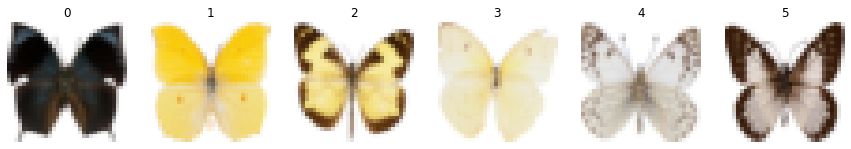

In [11]:
sample_data = next(iter(train_dataloader))
test_images = sample_data["images"][0:6].to(device)
I.wrap(test_images).normalize().show()

**For right now, we are starting with a quite small resolution, but we can think about larger later on.**

## 2. Schedular & Adding Noise

* Here with diffussers, we add some noise to an image & corrupt in a set of intervals (known as timesteps).
* Then we try to reverse the process when generating an image.

This noise adding part is handled by something called a schedular. Let's implement that.

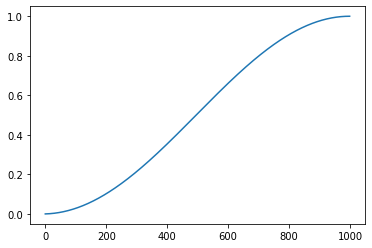

In [12]:
from diffusers import DDPMScheduler
n_steps = 1000
noise_scheduler = DDPMScheduler(num_train_timesteps=n_steps, beta_schedule='squaredcos_cap_v2')
plt.plot(1- noise_scheduler.alphas_cumprod)

Above graphs shows the amount of noise we add on each step to the image. We can change it via the `beta_schedule` algorithm.

Let's see how to add some noise.

torch.Size([6, 3, 32, 32])


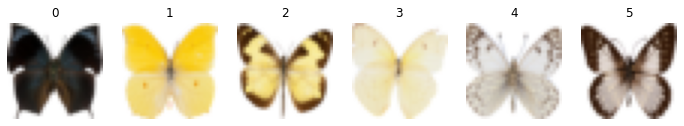

In [13]:
## this are the images
print(test_images.shape)
I.wrap(test_images).normalize().show(scale=2)

torch.Size([6, 3, 32, 32])


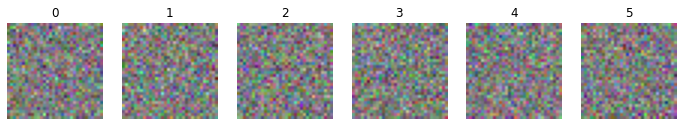

In [14]:
# let's generate some noise with the above shape
test_noise = torch.randn_like(test_images).to(device)
print(test_noise.shape)
I.wrap(test_noise).normalize().show(scale=2)

In [15]:
#now we need some steps
steps = torch.linspace(0, n_steps-1, 6).long().to(device)
steps

tensor([  0, 199, 399, 599, 799, 999], device='cuda:0')

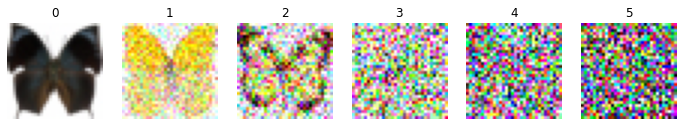

In [72]:
# let's add noise
noise_images = noise_scheduler.add_noise(test_images, test_noise, steps)
I.wrap(torch.clamp(noise_images / 2 + 0.5, 0, 1)).show(scale=2)

**See. This is how these images looks like with the added noise.**